In [276]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *
from scipy.stats import norm, sem
from process2_recovery import *
from utils_recovery import *
from recovery import *

#from chase.base import *
#from chase.utils import *
#from chase.fit import *

import pickle
import itertools
from mypy.viz import tableau20

FIGDEST = '/Users/markant/code/chase/chase/paper/results_figures'

In [280]:
problems = load_problem_set('glockner')

In [282]:
pars = {'minsamplesize': 2,
        'theta': 1,
        'N': 1000,}

m = CHASEProcessModel(problems=problems,
                      startdist='indifferent')

In [288]:
results = {}
arr = []

for theta in [1, 5]:
    pars['theta'] = theta
    
    for pid in problems:
        pars['probid'] = pid
        r = m(problems[pid], pars)
        results[(pid, theta)] = r
        
        arr.append([pid, theta, r['choice'].mean(), np.median(r['samplesize'])])

In [289]:
df = pd.DataFrame(arr, columns=['problem', 'theta', 'cp', 'ss_med'])

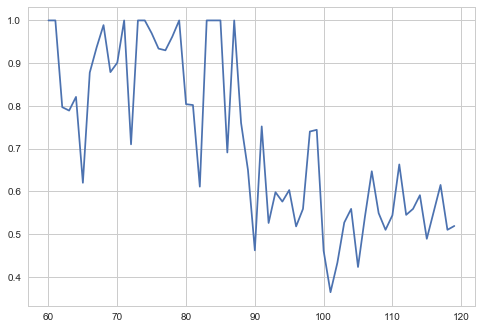

In [293]:
plt.plot(df[df.theta==5]['cp'])

In [295]:
for pid in problems:
    print pid
    print problems[pid]

0
[[[ 12.6    0.63]
  [  0.2    0.37]]

 [[ 27.3    0.06]
  [ 10.4    0.94]]]
1
[[[  4.1    0.4 ]
  [ 11.7    0.6 ]]

 [[ 26.     0.09]
  [ 10.4    0.91]]]
2
[[[ 18.     0.09]
  [  7.     0.91]]

 [[  3.4    0.61]
  [ 23.8    0.39]]]
3
[[[ 23.8    0.07]
  [  7.3    0.93]]

 [[  3.9    0.6 ]
  [ 23.     0.4 ]]]
4
[[[ 27.     0.06]
  [  7.3    0.94]]

 [[  3.9    0.6 ]
  [ 23.5    0.4 ]]]
5
[[[  0.1    0.6 ]
  [ 19.7    0.4 ]]

 [[ 10.6    0.95]
  [ 25.7    0.05]]]
6
[[[  1.1    0.59]
  [ 17.9    0.41]]

 [[ 23.5    0.08]
  [ 10.6    0.92]]]
7
[[[  7.6    0.94]
  [ 22.8    0.06]]

 [[ 20.2    0.45]
  [  5.9    0.55]]]
8
[[[  1.5    0.4 ]
  [ 13.     0.6 ]]

 [[ 26.8    0.07]
  [ 10.3    0.93]]]
9
[[[ 23.7    0.06]
  [  7.1    0.94]]

 [[ 24.     0.41]
  [  3.6    0.59]]]
10
[[[  1.6    0.1 ]
  [  8.7    0.9 ]]

 [[ 16.7    0.65]
  [  1.2    0.35]]]
11
[[[  0.4    0.08]
  [  8.4    0.92]]

 [[  8.6    0.39]
  [ 13.1    0.61]]]
12
[[[  9.3    0.95]
  [  0.1    0.05]]

 [[  3.5    0.6 ]
  [

## combine results

In [339]:
thetas = [1, 2, 3, 4, 5, 7, 9, 15]
gammas = [.6, 1, 1.4]

bf_cpt_pr = {}
bf_cpt_rf = {}
bf_chase = {}

problemsets = ['sixproblems', 'tpt', 'glockner']

for ps in problemsets:
    
    name = 'process_recovery_' + ps
    
    try:
        bf_cpt_pr[ps] = pd.read_csv('%s_cpt/%s_cpt(prelec_gamma,s|)_recovery_results.csv' % (name, name), index_col=0)
        bf_cpt_rf[ps] = pd.read_csv('%s_cpt_rf/%s_cpt_rf(prelec_gamma,s|)_recovery_results.csv' % (name, name), index_col=0)
        bf_chase[ps]  = pd.read_csv('%s_chase/%s_chase(prelec_gamma,theta|)_recovery_results.csv' % (name, name), index_col=0)
    except:
        pass

In [340]:
agg = {}
agg_cpt_rf = {}

#for ps in problemsets:
for ps in ['sixproblems', 'tpt', 'glockner']:
    df = bf_cpt_pr[ps]
    aggdf = df.groupby(['gen_theta', 'gen_prelec_gamma'])['bf_prelec_gamma'].agg({'bf_prelec_gamma_mn': np.median, 
                                                                                  'bf_prelec_gamma_se': sem})
    aggdf.reset_index(inplace=True)
    agg[ps] = aggdf
    
    df = bf_cpt_rf[ps]
    aggdf = df.groupby(['gen_theta', 'gen_prelec_gamma'])['bf_prelec_gamma'].agg({'bf_prelec_gamma_mn': np.median, 
                                                                                  'bf_prelec_gamma_se': sem})
    aggdf.reset_index(inplace=True)
    agg_cpt_rf[ps] = aggdf

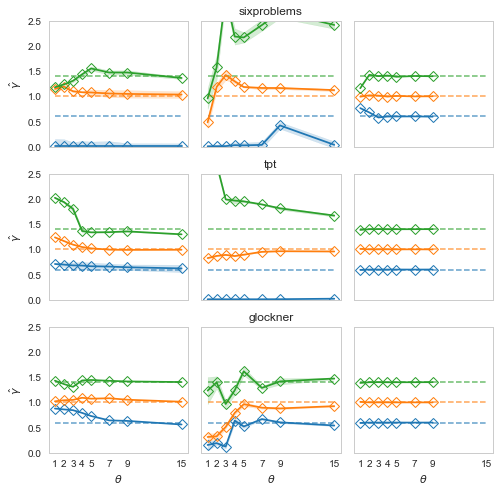

In [342]:
cols = [tableau20[i] for i in [0, 2, 4]]

fig, ax = plt.subplots(len(problemsets), 3, figsize=(7,7), sharey=True, sharex=True)


for axi in ax.ravel():
    
    for i, gamma in enumerate(gammas):
        axi.plot(thetas, np.ones(len(thetas))*gamma, '--', label=gamma, color=cols[i], alpha=.6)
    

#for j, ps in enumerate(problemsets):
for j, ps in enumerate(['sixproblems', 'tpt', 'glockner']):
    
    for i, gamma in enumerate(gammas):
        
        if ps in bf_cpt_pr:
            mn = agg[ps][agg[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma_mn'].values
            se = agg[ps][agg[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma_se'].values
            ax[j][0].fill_between(thetas, mn - se, mn + se, color=cols[i], alpha=.2)
            ax[j][0].plot(thetas, agg[ps][agg[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma_mn'].values, 
                          '-D', markerfacecolor='None', markeredgewidth=1, markeredgecolor=cols[i], color=cols[i])

        if ps in bf_cpt_rf:
            mn = agg_cpt_rf[ps][agg_cpt_rf[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma_mn'].values
            se = agg_cpt_rf[ps][agg_cpt_rf[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma_se'].values
            ax[j][1].fill_between(thetas, mn - se, mn + se, color=cols[i], alpha=.2)
            ax[j][1].plot(thetas, agg_cpt_rf[ps][agg_cpt_rf[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma_mn'].values, 
                          '-D', markerfacecolor='None', markeredgewidth=1, markeredgecolor=cols[i], color=cols[i])
        
        if ps in bf_chase:
            ax[j][2].plot(thetas[:-1], bf_chase[ps][bf_chase[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma'].values, 
                          '-D', markerfacecolor='None', markeredgewidth=1, markeredgecolor=cols[i], color=cols[i])

    ax[j][1].set_title(ps)
    
    
for axi in ax.ravel():
    axi.set_ylim(0,2.5)
    axi.grid(None)
    axi.set_xticks(thetas)
    
for i in range(len(problemsets)):
    ax[i][0].set_ylabel(r'$\hat\gamma$')
    ax[2][i].set_xlabel(r'$\theta$')
    
plt.tight_layout()
plt.show()
fig.savefig('%s/recovery.pdf' % FIGDEST, bbox_inches='tight')

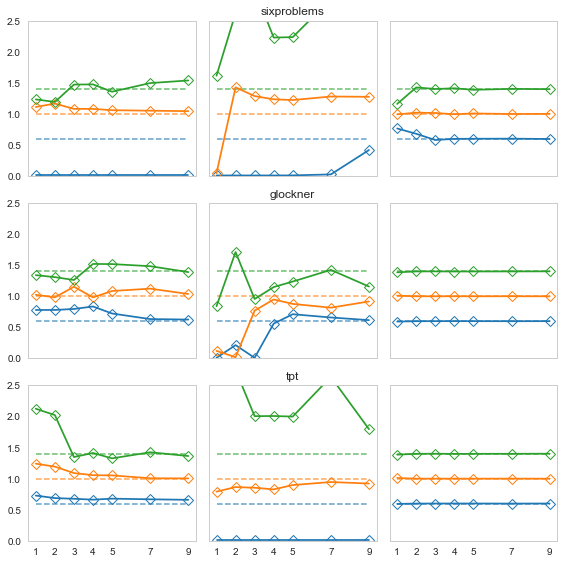

In [89]:
cols = [tableau20[i] for i in [0, 2, 4]]

fig, ax = plt.subplots(len(problemsets), 3, figsize=(8,8), sharey=True, sharex=True)


for axi in ax.ravel():
    
    for i, gamma in enumerate(gammas):
        axi.plot(thetas, np.ones(len(thetas))*gamma, '--', label=gamma, color=cols[i], alpha=.6)
    

for j, ps in enumerate(problemsets):

    for i, gamma in enumerate(gammas):
        
        if ps in bf_cpt_pr:
            ax[j][0].plot(thetas, bf_cpt_pr[ps][bf_cpt_pr[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma'].values, 
                          '-D', markerfacecolor='None', markeredgewidth=1, markeredgecolor=cols[i], color=cols[i])
            
        if ps in bf_cpt_rf:
            ax[j][1].plot(thetas, bf_cpt_rf[ps][bf_cpt_rf[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma'].values, 
                          '-D', markerfacecolor='None', markeredgewidth=1, markeredgecolor=cols[i], color=cols[i])
        
        if ps in bf_chase:
            ax[j][2].plot(thetas, bf_chase[ps][bf_chase[ps].gen_prelec_gamma==gamma]['bf_prelec_gamma'].values, 
                          '-D', markerfacecolor='None', markeredgewidth=1, markeredgecolor=cols[i], color=cols[i])

    ax[j][1].set_title(ps)
    
    
for axi in ax.ravel():
    axi.set_ylim(0,2.5)
    axi.grid(None)
    axi.set_xticks(thetas)
    
plt.tight_layout()
plt.show()

# why?

In [343]:
problems = load_problem_set('sixproblems')

In [716]:
pars = {'minsamplesize': 2,
        'switchfirst': True,
        'theta': 5,
        'N': 5000,
        'prelec_gamma': .6,
        'pref_units': 'sums', 
        'scale_threshold': False,
        'max_T': 1000}


m = CHASEProcessModel(problems=problems,
                      startdist='indifferent')

results = {}
arr = []

gammas = [.1, .4, .6, .8, 1, 1.4]

for theta in [50]:
    for gamma in gammas:
        pars['theta'] = theta
        pars['prelec_gamma'] = gamma

        for pid in problems:
            print 'problem %s' % pid
            pars['probid'] = pid
            r = m(problems[pid], pars)
            results[(pid, theta)] = r
            arr.append([pid, theta, gamma, r['choice'].mean(), np.median(r['samplesize'])])

problem 0
problem 1
35
0
13
problem 2
problem 3
problem 4
problem 5
problem 0
problem 1
151
0
69
problem 2
problem 3
problem 4
problem 5
problem 0
8
0
14
problem 1
320
0
134
problem 2
problem 3
6
0
14
problem 4
problem 5
problem 0
21
0
33
problem 1
539
0
345
problem 2
problem 3
42
0
33
problem 4
problem 5
problem 0
11
1
13
problem 1
956
12
673
problem 2
1
0
3
problem 3
14
0
13
problem 4
0
0
2
problem 5
20
0
22
problem 0
problem 1
997
0
1637
problem 2
problem 3
problem 4
problem 5


In [717]:
df = pd.DataFrame(arr, columns=['problem', 'theta', 'gamma', 'p(H)', 'median_ss'])

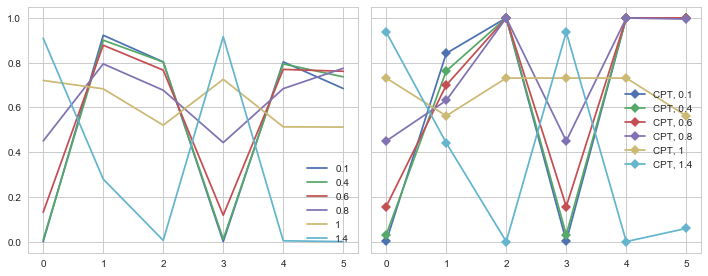

In [718]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for gamma in gammas:
    ax[0].plot(df[df.gamma==gamma]['p(H)'].values, label=gamma)
    
    cp = np.array([cpt.choice_prob(problems[pid], {'prelec_gamma': gamma, 's': 5}) for pid in problems])
    ax[1].plot(cp, '-D', label=('CPT, %s' % gamma))
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-.05,1.05)
ax[1].set_ylim(-.05,1.05)
plt.tight_layout()
plt.show()

In [632]:
for pid in problems:
    print pid
    print problems[pid]
    print expected_value(problems[pid][0]), expected_value(problems[pid][1])
    print

0
[[[ 3.   1. ]
  [ 0.   0. ]]

 [[ 4.   0.8]
  [ 0.   0.2]]]
3.0 3.2

1
[[[ 3.    0.25]
  [ 0.    0.75]]

 [[ 4.    0.2 ]
  [ 0.    0.8 ]]]
0.75 0.8

2
[[[-32.    0.1]
  [  0.    0.9]]

 [[ -3.    1. ]
  [  0.    0. ]]]
-3.2 -3.0

3
[[[-4.   0.8]
  [ 0.   0.2]]

 [[-3.   1. ]
  [ 0.   0. ]]]
-3.2 -3.0

4
[[[  3.    1. ]
  [  0.    0. ]]

 [[ 32.    0.1]
  [  0.    0.9]]]
3.0 3.2

5
[[[  3.00000000e+00   2.50000000e-01]
  [  0.00000000e+00   7.50000000e-01]]

 [[  3.20000000e+01   2.50000000e-02]
  [  0.00000000e+00   9.75000000e-01]]]
0.75 0.8



In [626]:
pars = {'minsamplesize': 2,
        'theta': 10000,
        'N': 10000,
        'prelec_gamma': 1,
        'pref_units': 'diffs', 
        'scale_threshold': False,
        'max_T': 5000,
        'probid': 2}


r = m(problems[2], pars)
print np.mean(r['choice'])

9827
0
173
0.9827


(array([     0.,      0.,      0.,      0.,      0.,  10000.,      0.,
             0.,      0.,      0.]),
 array([  9999.5,   9999.6,   9999.7,   9999.8,   9999.9,  10000. ,
         10000.1,  10000.2,  10000.3,  10000.4,  10000.5]),
 <a list of 10 Patch objects>)

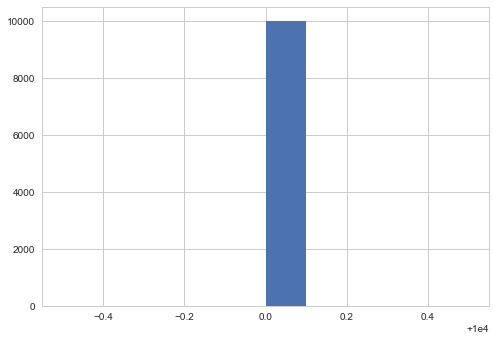

In [587]:
plt.hist(r['samplesize'])

0.91290000000000004

In [571]:
gamma = 1
cp = np.array([cpt.choice_prob(problems[pid], {'prelec_gamma': gamma, 's': 15}, use_cache=False) for pid in problems])
print cp

[ 0.95257413  0.6791787   0.95257413  0.95257413  0.95257413  0.6791787 ]


In [694]:
gen_pars = {'N': 20,
            'minsamplesize': 2,
            'prelec_gamma': 0.6,
            'theta': 5,
            'pref_units': 'diffs',
            'scale_threshold': False,
            'switchfirst': True}

In [695]:
from recovery import *
for iteration in range(10):
    pth = simulate_data_pth('process_recovery_sixproblems', gen_pars, iteration=iteration)
    data_i = pd.read_csv(pth, index_col=0)
    data_i['iteration'] = iteration
    
    if iteration == 0:
        data = data_i
    else:
        data = pd.concat((data, data_i))

In [696]:
data

,subject,problem,group,choice,samplesize,Lx0,Lp0,Lf0,Lx1,Lp1,Lf1,Hx0,Hp0,Hf0,Hx1,Hp1,Hf1,iteration
0,0,0,0,0,13,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.750,0.0,0.200,0.250,0
1,1,0,0,0,3,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.000,0.0,0.200,1.000,0
2,2,0,0,0,11,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.667,0.0,0.200,0.333,0
3,3,0,0,0,14,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.714,0.0,0.200,0.286,0
4,4,0,0,0,9,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.667,0.0,0.200,0.333,0
5,5,0,0,0,15,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.778,0.0,0.200,0.222,0
6,6,0,0,0,11,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.667,0.0,0.200,0.333,0
7,7,0,0,0,9,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.500,0.0,0.200,0.500,0
8,8,0,0,0,27,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.846,0.0,0.200,0.154,0
9,9,0,0,0,15,3.0,1.00,1.000,0.0,0.00,0.000,4.0,0.800,0.667,0.0,0.200,0.333,0


In [697]:
cpdf = data.groupby(['problem', 'iteration']).apply(lambda d: d.choice.mean()).reset_index()
cpdf.columns = ['problem', 'iteration', 'cp']

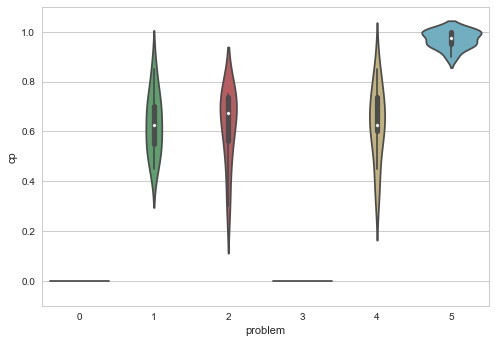

In [698]:
fig, ax = plt.subplots()
sns.violinplot(x='problem', y='cp', data=cpdf, ax=ax)
ax.set_ylim(-.1,1.1)
plt.show()

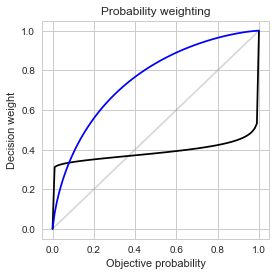

In [719]:
delta = 1
gamma = .1

from chase.cpt import w_prelec
p = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(figsize=(4,4))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)

delta = 1
gamma = .1
axi.plot(p, w_prelec(p, delta, gamma), '-', color='black')

delta = .3
gamma = 1.4
axi.plot(p, w_prelec(p, delta, gamma), '-', color='blue')

axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
plt.tight_layout()
plt.show()

# glockner

In [88]:
def problem_array(row):
    return np.array([[row[['g1o1', 'g1p1']].values, row[['g1o2', 'g1p2']].values],
                     [row[['g2o1', 'g2p1']].values, row[['g2o2', 'g2p2']].values]])

data = pd.read_csv('paper/data/glockner2016/Glockner2016_EB_all.csv', index_col=0)
data = data[(data.description==0) & (data.exp==3)]
probdf = data[['g1o1', 'g1p1', 'g1o2', 'g1p2', 'g2o1', 'g2p1', 'g2o2', 'g2p2']].drop_duplicates().reset_index()

problems = {}
for i, row in probdf.iterrows():
    p = problem_array(row)
    evA = expected_value(p[0])
    evB = expected_value(p[1])
    if evA > evB:
        problems[i] = np.array([p[1], p[0]])
    else:
        problems[i] = p

In [137]:
gen_pars = {'N': 20,
            'theta': .5,
            'p_stay': 0.,
            'tau': 0.001,}

In [138]:
name = 'process_recovery_glockner'
simulate_data(name, problems, gen_pars)

In [140]:
fitting = ['theta']
fixed = {}
fit_simulated_data(name, problems, gen_pars, fitting, fixed)

theta


process_model.py:177: RuntimeWarning: invalid value encountered in divide
  p_stop_A = p_stop_A/float(p_stop_A.sum())


0.917811155319
0.80924987793
0.813747167587
0.792260885239
0.809880018234
0.811038970947
0.808965921402
2.13906788826
0.896190166473
0.823847055435
0.808786869049
0.820312976837
0.819098949432
0.807420969009
0.810518026352
0.82146191597
0.820601940155
0.825330018997
0.81204199791
0.865764856339
0.844612836838
0.870594024658
0.835923194885
0.82336807251
0.840057849884
0.817821025848
0.827255964279
0.835214138031
0.839365959167
0.914302825928
0.87748503685
0.867467880249
0.853006839752
0.884142875671
0.905627965927
0.872772216797
0.826954126358
0.840970993042
0.848645925522
0.884171962738
0.912292957306
0.860854148865
0.818699121475
0.84216094017
0.976997852325
0.928861141205
0.88970208168
0.875166893005
0.855700016022
0.865597009659
0.850872039795
0.867069959641
0.817521095276
0.826009988785
0.871839046478
0.859622955322
0.839044809341
0.829310894012
0.821818113327
0.844820022583
887.150324887 11573.8005411
[ 3.] 12460.950866
0.854779005051
0.943676948547
0.881448030472
0.93733215332
0.

KeyboardInterrupt: 

# Binary gambles

In [107]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}

In [108]:
problems = {0: problems[0]}

In [660]:
cp_sim = []
cp_pred = []
ss_sim = []
ss_pred = []
bf_par = []

thetas = [1, 3, 5, 7, 9]

n_prob = 1

for theta in thetas:
    
    gen_pars = {'N': N,
               'theta': theta,
               'p_stay': 0.}
    fitting = ['theta', 'p_stay']
    data, best, pred = sim_and_fit([], gen_pars, fitting, problems=problems)
    
    bf_par.append(best[fitting].values)
    
    samplesize = [data[data.problem==pid].samplesize.values-1 for pid in range(n_prob)]
    choices = [data[data.problem==pid].choice.values for pid in range(n_prob)]
    
    cp_sim.append([choices[i].mean() for i in range(n_prob)])
    cp_pred.append([pred[pid]['p_resp'][1] for pid in range(n_prob)])
    
    ss_sim.append([samplesize[pid].mean() for pid in range(n_prob)])
    ss_pred.append([pred[pid]['exp_samplesize'][0,1]*cp_pred[-1][pid] + pred[pid]['exp_samplesize'][0,0]*(1-cp_pred[-1][pid]) \
                    for pid in range(n_prob)])

1 0.444 0.091
3 0.516 2.447
5 0.524 6.243
7 0.548 15.076
9 0.581 22.601


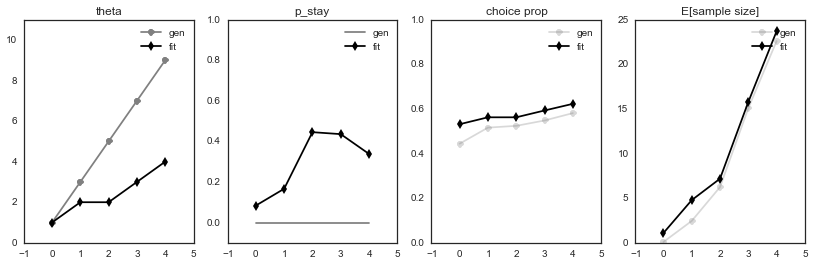

In [663]:
cols = ['gray', 'black']

fig, ax = plt.subplots(1, 4, figsize=(14,4))

ax[0].plot(thetas, '-o', color=cols[0], label='gen')
ax[0].plot([b[0] for b in bf_par], '-d', color=cols[1], label='fit')
ax[0].set_ylim(0, 11)
ax[0].set_title('theta')

ax[1].plot([0 for _ in range(len(thetas))], color=cols[0], label='gen')
ax[1].plot([b[1] for b in bf_par], '-d', color=cols[1], label='fit')
ax[1].set_ylim(-.1, 1)
ax[1].set_title('p_stay')

ax[2].plot(cp_sim, '-o', color=cols[0], alpha=.3, label='gen')
ax[2].plot(cp_pred, '-d', color=cols[1], label='fit')
ax[2].set_ylim(0, 1)
ax[2].set_title('choice prop')

ax[3].plot(ss_sim, '-o', color=cols[0], alpha=.3, label='gen')
ax[3].plot(ss_pred, '-d', color=cols[1], label='fit')
ax[3].set_title('E[sample size]')

for axi in ax:
    axi.set_xlim(-1, len(thetas))
    axi.legend()

plt.show()

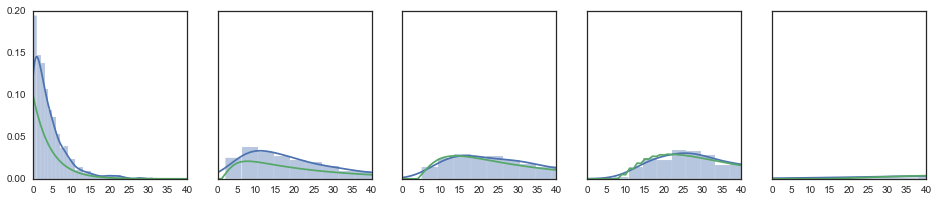

In [665]:
# compare sample size distributions
fig, ax = plt.subplots(1, len(thetas), figsize=(16,3), sharey=True)
for i in range(len(thetas)):
    for pid in range(n_prob):
        sns.distplot(ss_all[i], ax=ax[i])
        ax[i].plot(ss_pred_all[i])

    ax[i].set_xlim(0,40)
plt.show()

In [598]:
N = 1000
genpars = {'N': N,
           'theta': 6,
           'p_stay': 0.1}
samplesize, choices = simulate_process(problems, genpars)
print choices.mean(axis=1)

data = []
for i, problem in enumerate(problems):
    arr = np.transpose((np.ones(N, int)*np.nan, np.ones(N, int)*i, np.zeros(N, int), choices[i,:], samplesize[i,:]))
    data.append(arr)
data = pd.DataFrame(np.concatenate(data), columns=['subject', 'problem', 'group', 'choice', 'samplesize'])

[ 0.538  0.516  0.533  0.541  0.518  0.444]


In [599]:
N_ITER = 1
SIM_ID = 'recover_process_data'
OUTDIR = 'chase_fitresults_recover_process_data'
FIXED = {}
PARSETS = [['theta', 'p_stay']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    
    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent')
        
    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)
    
    print results.sort('nllh')

recover_process_data(p_stay,theta|)
0/10
['theta']: [ 1.]
iteration            0
success           True
nllh          35010.43
k                    2
N                 6000
bic           70038.26
theta                1
p_stay       0.9842529
Name: 0, dtype: object
recover_process_data(p_stay,theta|)
1/10
['theta']: [ 2.]
iteration            0
success           True
nllh          35769.38
k                    2
N                 6000
bic           71556.15
theta                2
p_stay       0.9324219
Name: 1, dtype: object
recover_process_data(p_stay,theta|)
2/10
['theta']: [ 3.]
iteration            0
success           True
nllh          36669.42
k                    2
N                 6000
bic           73356.23
theta                3
p_stay       0.8355469
Name: 2, dtype: object
recover_process_data(p_stay,theta|)
3/10
['theta']: [ 4.]
iteration            0
success           True
nllh          38897.35
k                    2
N                 6000
bic            77812.1
theta    

In [600]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

index                                           0
Unnamed: 0                                      0
iteration                                       0
success                                      True
nllh                                     35010.43
k                                               2
N                                            6000
bic                                      70038.26
theta                                           1
p_stay                                  0.9842529
sim_id        recover_process_data(p_stay,theta|)
Name: 0, dtype: object


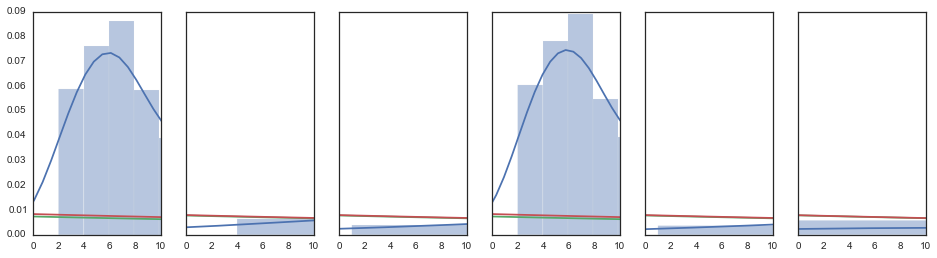

In [601]:
fig, ax = plt.subplots(1, 6, figsize=(16,4), sharey=True)
for pid in problems:
    sns.distplot(samplesize[pid]-1, ax=ax[pid])
    
    ax[pid].plot(np.array(pred[pid]['p_resp_t'][:,0])[:,0])
    ax[pid].plot(np.array(pred[pid]['p_resp_t'][:,1])[:,0])

    ax[pid].set_xlim(0,10)
plt.show()

# Recovery

In [93]:
from cogmod import cpt as cptmodel

def fit_chase(problems, data, fit_pars):
        
    FIXED = {'dt': .1}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [1, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [3]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
#problems = {i: arr[i].reshape((2,2,2)) for i in range(1)}
#problems = [arr[i].reshape((2,2,2)) for i in range(len(arr))]

In [132]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [75]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)

## Single problem, normally distributed outcomes

In [94]:
problems = {i: generate_normal_problem([[1, 1.], [2, 1.]], n_x=5) for i in range(1)}

In [96]:
N = 10000  # N has to be low enough for sampling error to have an impact! 

gen_pars = []
for gamma in [1.]:
    for theta in [10, 15]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})

In [97]:
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.817]
[ 0.898]


In [13]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay', 'tau'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

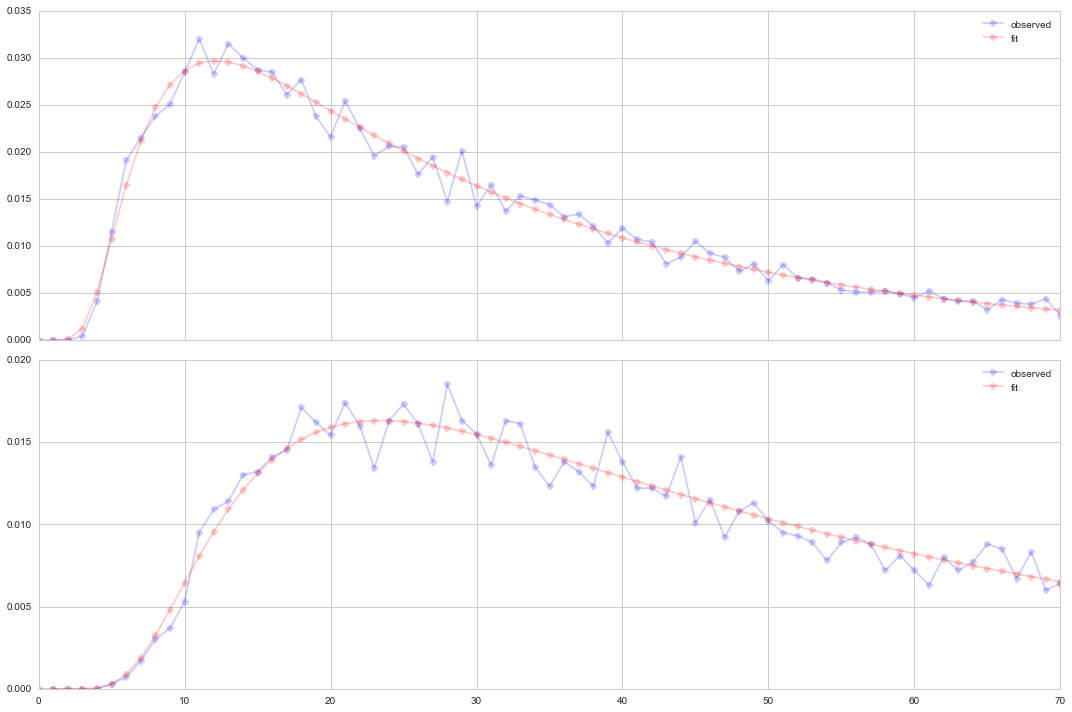

In [99]:
fig, axi = plt.subplots(len(gen_pars), 1, figsize=(15,10), sharex=True)

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    ax = axi[i]
    
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(ss, '-o', color='blue', alpha=.2, label='observed')
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-o', color='red', alpha=.2, label='fit')
        ax.set_xlim(0, 70)
        ax.legend()
plt.tight_layout()
plt.show()

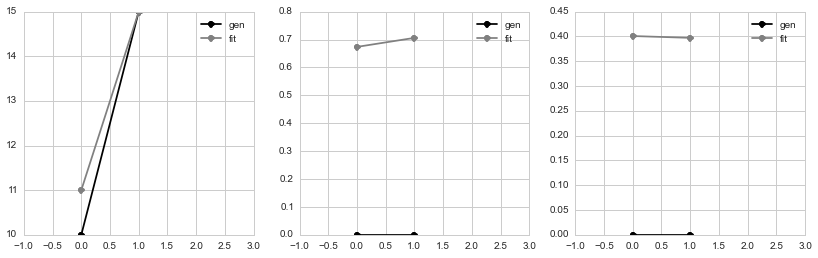

In [100]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': []}
true_par = {'theta': [], 'p_stay': [], 'tau': []}

for gp in gen_pars:
    
    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    for par in ['theta', 'p_stay', 'tau']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 3, figsize=(14,4))

for i, par in enumerate(['theta', 'p_stay', 'tau']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## multiple problems, normally distributed outcomes

In [101]:
problems = {i: generate_normal_problem([[1, 1.], [2, 1.]], n_x=3) for i in range(20)}

In [102]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [113]:
N = 1000

gen_pars = []
for theta in [5, 10]:
    for gamma in [.5, 1., 1.5]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      

#problems_exp_by_subj = {}
#for i in range(N):
#    for pid in problems:
#        problems_exp_by_subj['%s-%s' % (pid, i)] = problems_exp[pid][i]

[ 0.919  0.779  0.272  0.875  0.865  0.78   0.961  0.315  1.     0.865
  0.053  0.564  0.29   0.437  0.774  0.657  0.451  0.915  0.883  0.969]
[ 0.89   0.767  0.242  0.946  0.945  0.81   0.97   0.266  1.     0.877
  0.071  0.644  0.307  0.476  0.69   0.613  0.47   0.912  0.978  0.963]
[ 0.834  0.712  0.297  0.936  0.906  0.836  0.95   0.234  1.     0.803
  0.092  0.656  0.321  0.489  0.681  0.599  0.479  0.874  0.996  0.972]
[ 0.995  0.694  0.191  0.976  0.96   0.896  0.996  0.184  1.     0.95
  0.079  0.51   0.373  0.406  0.871  0.711  0.515  0.994  0.938  0.997]
[ 0.971  0.88   0.13   0.997  0.997  0.945  1.     0.115  1.     0.969
  0.007  0.542  0.143  0.397  0.821  0.708  0.509  0.986  1.     0.998]
[ 0.955  0.811  0.108  0.993  0.98   0.942  0.998  0.1    1.     0.929
  0.017  0.551  0.158  0.433  0.795  0.673  0.433  0.961  1.     0.996]


In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

In [ ]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], '-o', color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], '-o', color='gray')
    ax.set_ylim(0, 1)
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

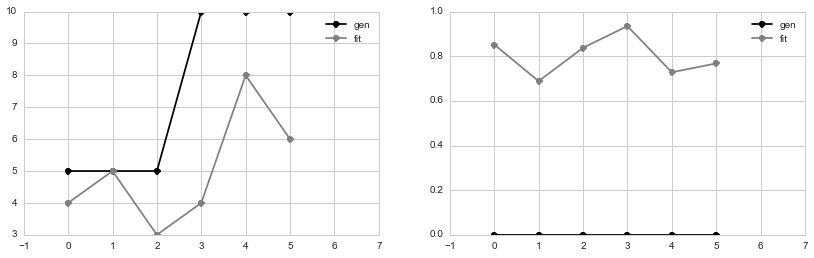

In [116]:
# recovered parameters
bf_par   = {'theta': [], 'p_stay': [], 'tau': []}
true_par = {'theta': [], 'p_stay': [], 'tau': []}

for gp in gen_pars:
    
    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    for par in ['theta', 'p_stay']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

for i, par in enumerate(['theta', 'p_stay']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## fit gamma

In [ ]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'p_stay', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

In [ ]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    ax.set_ylim(0,1)
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

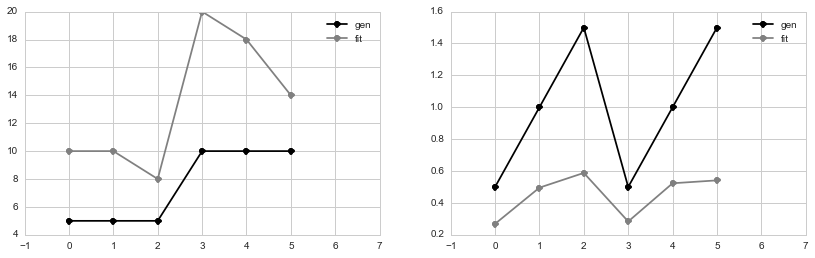

In [119]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}
true_par = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}

for gp in gen_pars:
    
    theta = gp['theta']
    #p_stay = gp['p_stay']
    p_stay = 0.
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    true_par['prelec_gamma'].append(gamma)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    #for par in ['theta', 'p_stay', 'tau', 'prelec_gamma']:
    for par in ['theta', 'prelec_gamma']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

#for i, par in enumerate(['theta', 'p_stay', 'tau', 'prelec_gamma']):
for i, par in enumerate(['theta', 'prelec_gamma']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()

## TPT

In [90]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)

In [91]:
cpt_fits_obj = {}
cpt_fits_exp = {}
chase_fits = {}
N_FIT_ITER = 1

In [92]:
N = 200  # N has to be low enough for sampling error to have an impact! 

gen_pars = []
for theta in [1, 2, 3, 4, 5]:
    for gamma in [.7, 1., 1.3]:
        for p_stay in [0.]:
        
            gen_pars.append({'N': N,
                             'theta': theta,
                             'p_stay': p_stay,
                             'prelec_gamma': gamma})
            
cols = ['theta', 'p_stay', 'gamma', 'subject', 'problem', 'problem-subject', 'group', 'choice', 'samplesize']
df = pd.DataFrame(columns=cols)

for gp in gen_pars:

    samplesize, choices, problems_exp = simulate_process(problems, gp, relfreq=True)
    print np.round([choices[pid].mean() for pid in problems], 3)

    data = []
    for pid in problems:
        arr = np.transpose(([gp['theta'] for _ in range(N)], 
                            [gp['p_stay'] for _ in range(N)],
                            [gp['prelec_gamma'] for _ in range(N)],
                            range(N), 
                            [pid for _ in range(N)], 
                            [('%s-%s' % (pid, i)) for i in range(N)],
                            np.zeros(N, int), 
                            np.array(choices[pid], int), np.array(samplesize[pid], int)))
        data.append(arr)
    data = pd.DataFrame(np.concatenate(data, axis=0), columns=cols)
    df = pd.concat((df, data))

df = df.convert_objects(convert_numeric=True)      



[ 0.41   0.46   0.46   0.505  0.49   0.47   0.63   0.51   0.485  0.31   0.56
  0.495  0.51   0.465  0.525  0.53   0.53   0.49   0.5    0.65   0.52
  0.545  0.575  0.485  0.47   0.565  0.455  0.585  0.485  0.66   0.55
  0.475  0.52   0.55   0.495  0.37   0.595  0.43   0.81   0.525  0.535
  0.495  0.48   0.52   0.545  0.49   0.505  0.465  0.64   0.525  0.455  0.7
  0.52   0.52   0.49   0.555  0.495  0.5    0.525  0.49 ]
[ 0.505  0.51   0.49   0.53   0.48   0.52   0.64   0.53   0.5    0.5    0.545
  0.51   0.515  0.48   0.475  0.465  0.515  0.5    0.51   0.61   0.595
  0.56   0.58   0.605  0.58   0.59   0.47   0.64   0.465  0.785  0.59
  0.465  0.52   0.555  0.595  0.44   0.61   0.44   0.75   0.51   0.5    0.545
  0.54   0.475  0.5    0.465  0.475  0.465  0.585  0.515  0.415  0.78
  0.515  0.52   0.54   0.54   0.405  0.47   0.5    0.53 ]
[ 0.545  0.505  0.485  0.48   0.48   0.56   0.595  0.53   0.52   0.54   0.47
  0.485  0.525  0.535  0.535  0.515  0.49   0.495  0.51   0.585  0.54   0.57

In [94]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'tau'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 0.7, 'p_stay': 0.0, 'N': 200}
recover_process_data(tau,theta|)
0/10
['theta']: [ 1.]
iteration           0
success          True
nllh         77556.61
k                   2
N               12000
bic            155132
theta               1
tau               0.5
Name: 0, dtype: object
recover_process_data(tau,theta|)
1/10
['theta']: [ 2.]
iteration            0
success           True
nllh           25550.5
k                    2
N                12000
bic           51119.78
theta                2
tau          0.9999992
Name: 1, dtype: object
recover_process_data(tau,theta|)
2/10
['theta']: [ 3.]
iteration            0
success           True
nllh          30587.91
k                    2
N                12000
bic            61194.6
theta                3
tau          0.9999998
Name: 2, dtype: object
recover_process_data(tau,theta|)
3/10
['theta']: [ 4.]
iteration            0
success           True
nllh          34454.31
k                    2
N               

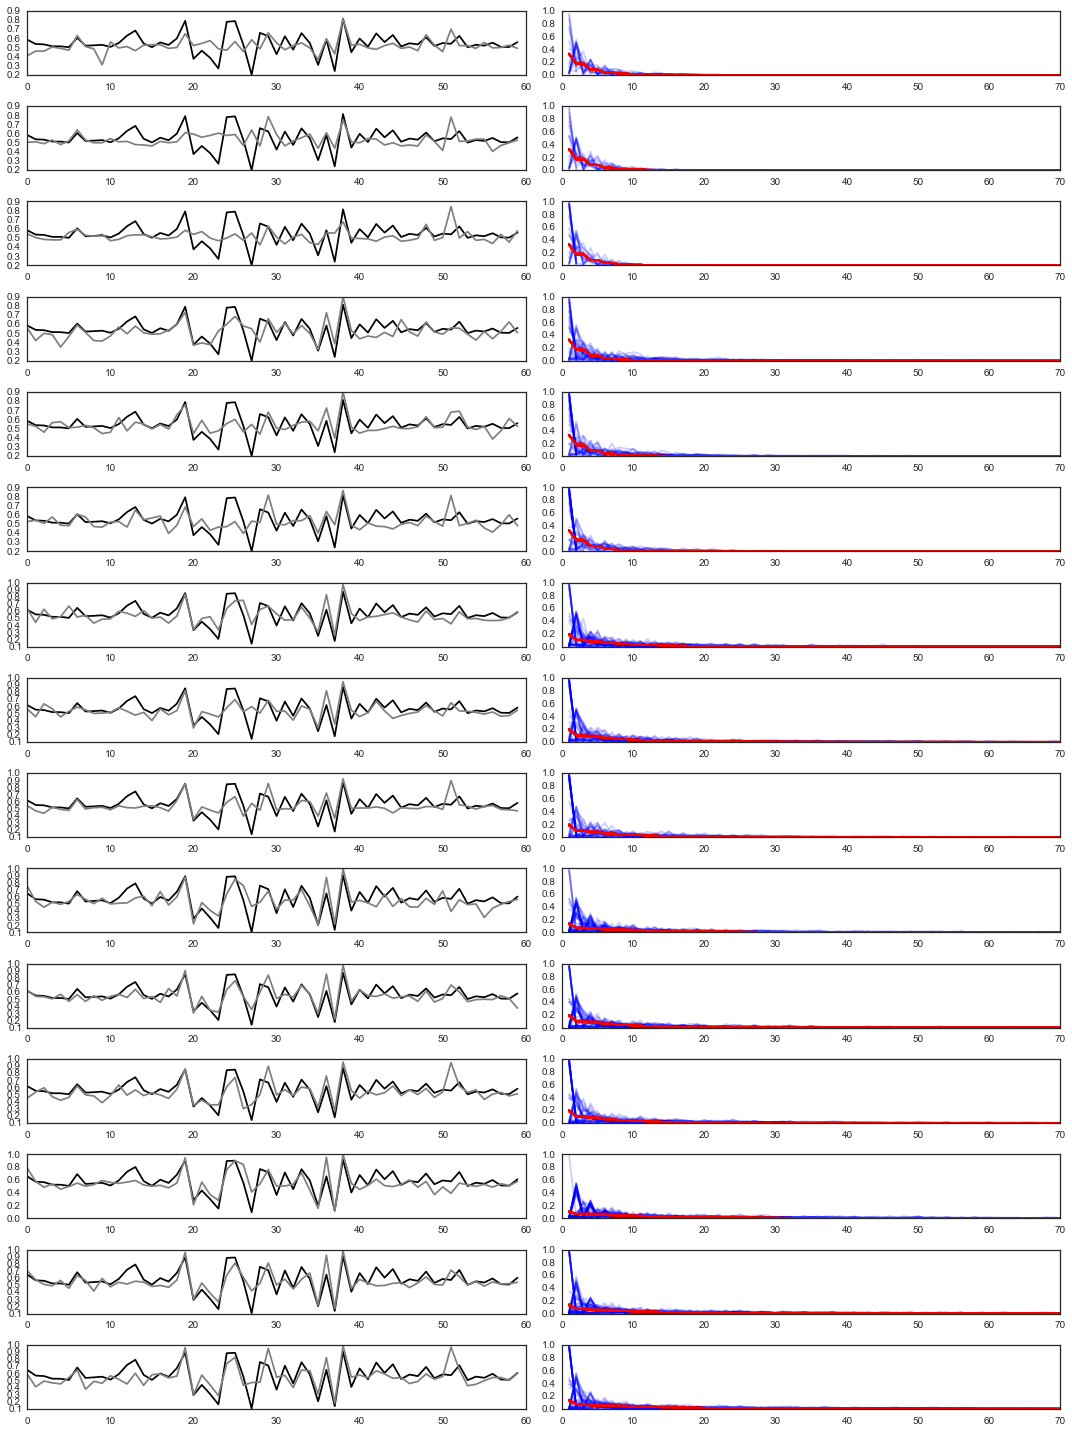

In [96]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

### fit gamma

In [97]:
for gp in gen_pars:
    
    print gp
    theta  = gp['theta']
    p_stay = gp['p_stay']
    gamma  = gp['prelec_gamma']
    k = (theta, p_stay, gamma)
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]
    
    
    # fit CPT (objective)
    #cpt_fits_obj[k] = cptmodel.fit(problems, 
    #                          data, 
    #                          'cptfit_6problems', 
    #                          fixed={}, fitting=fitting_cpt,
    #                          niter=N_FIT_ITER)
    #print cpt_fits_obj[k].sort('llh')


    # fit CPT (experienced)
    #cpt_fits_exp[k] = cptmodel.fit(problems_exp_by_subj, 
    #                                           data_exp, 
    #                                           'cptfit_6problems_exp', 
    #                                           fixed={}, fitting=fitting_cpt,
    #                                   niter=N_FIT_ITER)
    #print cpt_fits_exp[k].sort('llh')
    

    # fit CHASE
    best, pred = fit_chase(problems, data, ['theta', 'prelec_gamma'])
    chase_fits[k] = {'best': best, 'pred': pred}
    print best

{'theta': 1, 'prelec_gamma': 0.7, 'p_stay': 0.0, 'N': 200}
recover_process_data(prelec_gamma,theta|)
0/10
['theta']: [ 1.]
iteration               0
success              True
nllh             77556.02
k                       2
N                   12000
bic              155130.8
theta                   1
prelec_gamma    0.9689453
Name: 0, dtype: object
recover_process_data(prelec_gamma,theta|)
1/10
['theta']: [ 2.]
iteration              0
success             True
nllh            27418.38
k                      2
N                  12000
bic             54855.54
theta                  2
prelec_gamma     1.04375
Name: 1, dtype: object
recover_process_data(prelec_gamma,theta|)
2/10
['theta']: [ 3.]
iteration              0
success             True
nllh            36652.81
k                      2
N                  12000
bic              73324.4
theta                  3
prelec_gamma    1.066504
Name: 2, dtype: object
recover_process_data(prelec_gamma,theta|)
3/10
['theta']: [ 4.]
iteratio

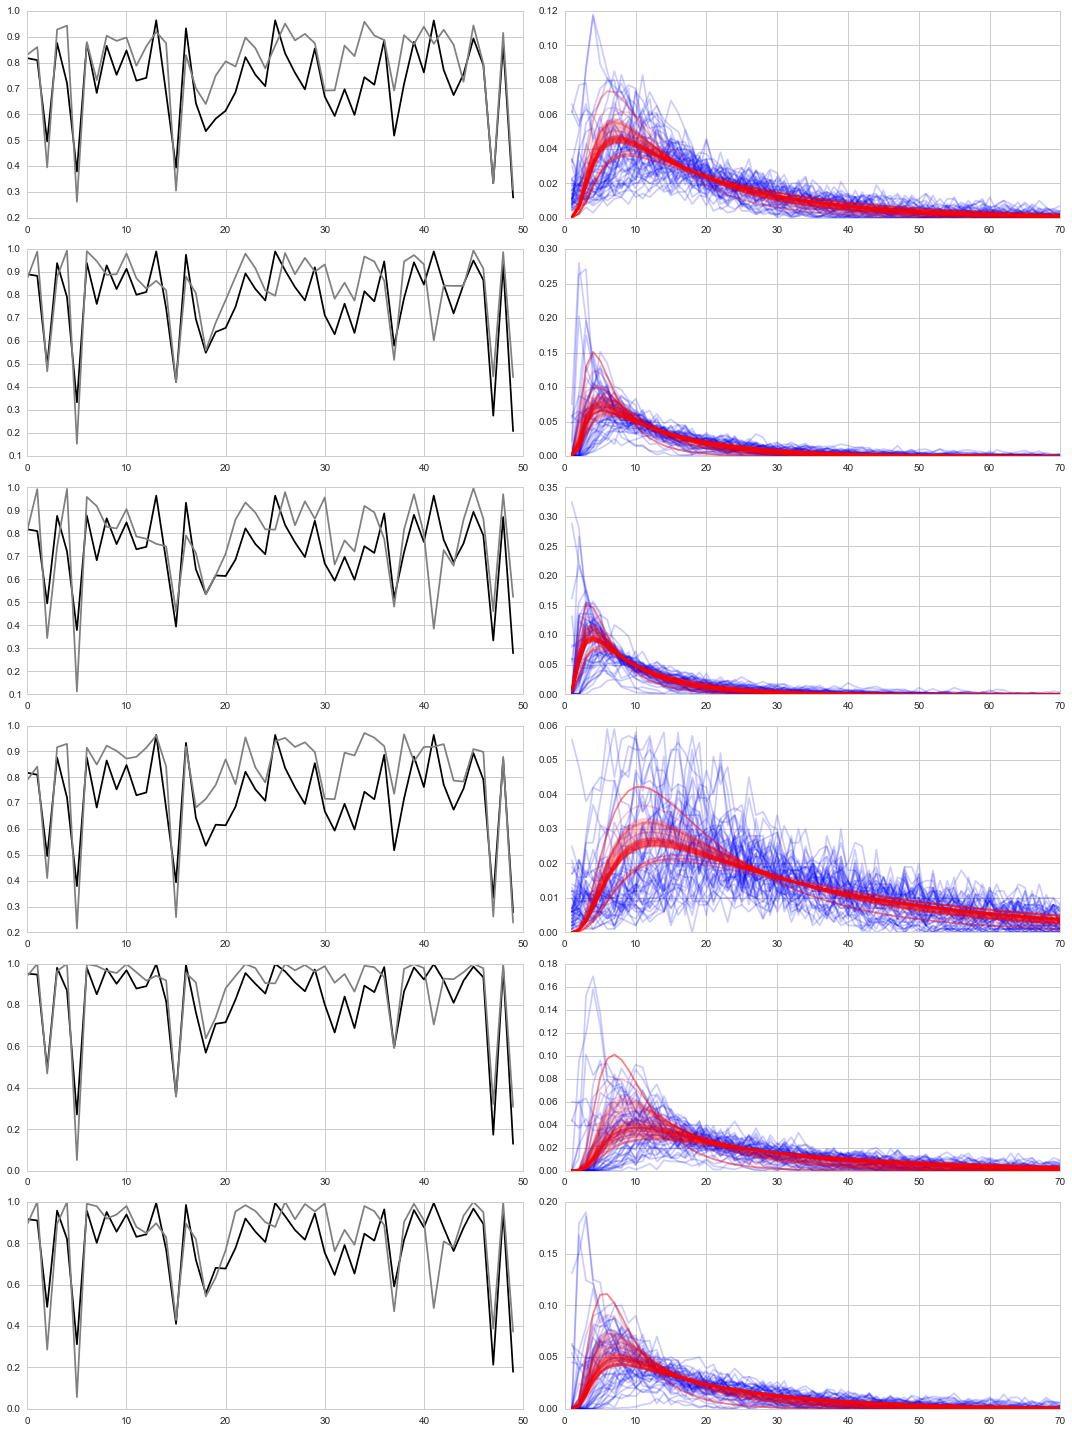

In [80]:
fig, axi = plt.subplots(len(gen_pars), 2, figsize=(15,20))

for i, gp in enumerate(gen_pars):

    theta = gp['theta']
    p_stay = gp['p_stay']
    gamma = gp['prelec_gamma']
    
    data = df[(df['p_stay']==p_stay) &
              (df['theta']==theta) &
              (df['gamma']==gamma)]

    f = chase_fits[((theta, p_stay, gamma))]
    pred = f['pred']
    
    # choice proportions
    ax = axi[i][0]
    ax.plot([predicted_cp(pred[pid]) for pid in data.problem.unique()], color='black')
    ax.plot([observed_cp(grp) for j, grp in data.groupby('problem')], color='gray')
    
    # sample size
    ax = axi[i][1]
    for i, grp in data.groupby('problem'):
        #sns.distplot(grp.samplesize, hist=True, bins=300, ax=ax)
        ss = observed_samplesize(grp)
        ax.plot(range(1, len(ss)), ss[1:], '-', color='blue', alpha=.2)
        
    for pid in data.problem.unique():
        pred_ss = predicted_samplesize(pred[pid])
        ax.plot(range(1, len(pred_ss)+1), pred_ss, '-', color='red', alpha=.2)
        ax.set_xlim(0, 70)
        #ax.legend()
        

plt.tight_layout()
plt.show()

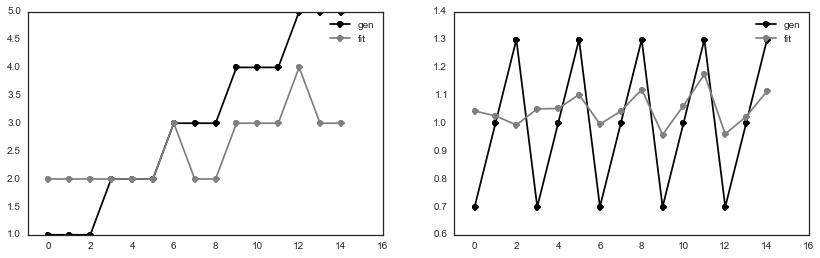

In [99]:
bf_par   = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}
true_par = {'theta': [], 'p_stay': [], 'tau': [], 'prelec_gamma': []}

for gp in gen_pars:
    
    theta = gp['theta']
    #p_stay = gp['p_stay']
    p_stay = 0.
    gamma = gp['prelec_gamma']
    tau = 0.
    
    true_par['theta'].append(theta)
    true_par['p_stay'].append(p_stay)
    true_par['tau'].append(tau)
    true_par['prelec_gamma'].append(gamma)
    
    f = chase_fits[((theta, p_stay, gamma))]
    best = f['best']
    #for par in ['theta', 'p_stay', 'tau', 'prelec_gamma']:
    for par in ['theta', 'prelec_gamma']:
        bf_par[par].append(best[par])

cols = ['gray', 'black']

fig, ax = plt.subplots(1, 2, figsize=(14,4))

#for i, par in enumerate(['theta', 'p_stay', 'tau', 'prelec_gamma']):
for i, par in enumerate(['theta', 'prelec_gamma']):
    ax[i].plot(true_par[par], '-o', color='black', label='gen')
    ax[i].plot(bf_par[par], '-o', color='gray', label='fit')

for axi in ax:
    axi.set_xlim(-1, len(gen_pars) + 1)
    axi.legend()
plt.show()